In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sys
sys.path.append('..')

import torch
import open_clip
from PIL import Image
from open_clip import SimpleTokenizer
from transformers import CLIPFeatureExtractor, CLIPModel, CLIPTextModel, CLIPTokenizer
from diffusers import DiffusionPipeline, UNet2DConditionModel, PNDMScheduler, AutoencoderKL

from images_mixing import CLIPGuidedImagesMixingStableDiffusion
from utils import show_images

### Load all diffusion modules

In [2]:
feature_extractor = CLIPFeatureExtractor.from_pretrained(
    "laion/CLIP-ViT-B-32-laion2B-s34B-b79K"
)
clip_model = CLIPModel.from_pretrained(
    "laion/CLIP-ViT-B-32-laion2B-s34B-b79K", torch_dtype=torch.float16
).to('cuda')


coca_model = open_clip.create_model('coca_ViT-L-14', pretrained='laion2B-s13B-b90k').to('cuda')
coca_model.dtype = torch.float16
coca_transform = open_clip.image_transform(
    coca_model.visual.image_size,
    is_train = False,
    mean = getattr(coca_model.visual, 'image_mean', None),
    std = getattr(coca_model.visual, 'image_std', None),
)
coca_tokenizer = SimpleTokenizer()

repo_id = 'CompVis/stable-diffusion-v1-4'
vae = AutoencoderKL.from_pretrained(repo_id, subfolder="vae", torch_dtype=torch.float16).to("cuda")
unet = UNet2DConditionModel.from_pretrained(repo_id, subfolder="unet", torch_dtype=torch.float16).to("cuda")
text_encoder = CLIPTextModel.from_pretrained(repo_id, subfolder="text_encoder", torch_dtype=torch.float16).to("cuda")
scheduler = PNDMScheduler.from_pretrained(repo_id, subfolder="scheduler", torch_dtype=torch.float16)
tokenizer = CLIPTokenizer.from_pretrained(repo_id, subfolder="tokenizer", torch_dtype=torch.float16)

/home/user/Projects/denk_baseline/venv/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


### Create DiffusionPipeline from modules

In [3]:
mixing_pipeline = CLIPGuidedImagesMixingStableDiffusion(
    vae=vae,
    text_encoder=text_encoder,
    clip_model=clip_model,
    tokenizer=tokenizer,
    unet=unet,
    scheduler=scheduler,
    feature_extractor=feature_extractor,
    coca_model=coca_model,
    coca_tokenizer=coca_tokenizer,
    coca_transform=coca_transform,
)
mixing_pipeline.enable_attention_slicing()
mixing_pipeline = mixing_pipeline.to("cuda")

  0%|          | 0/30 [00:00<?, ?it/s]

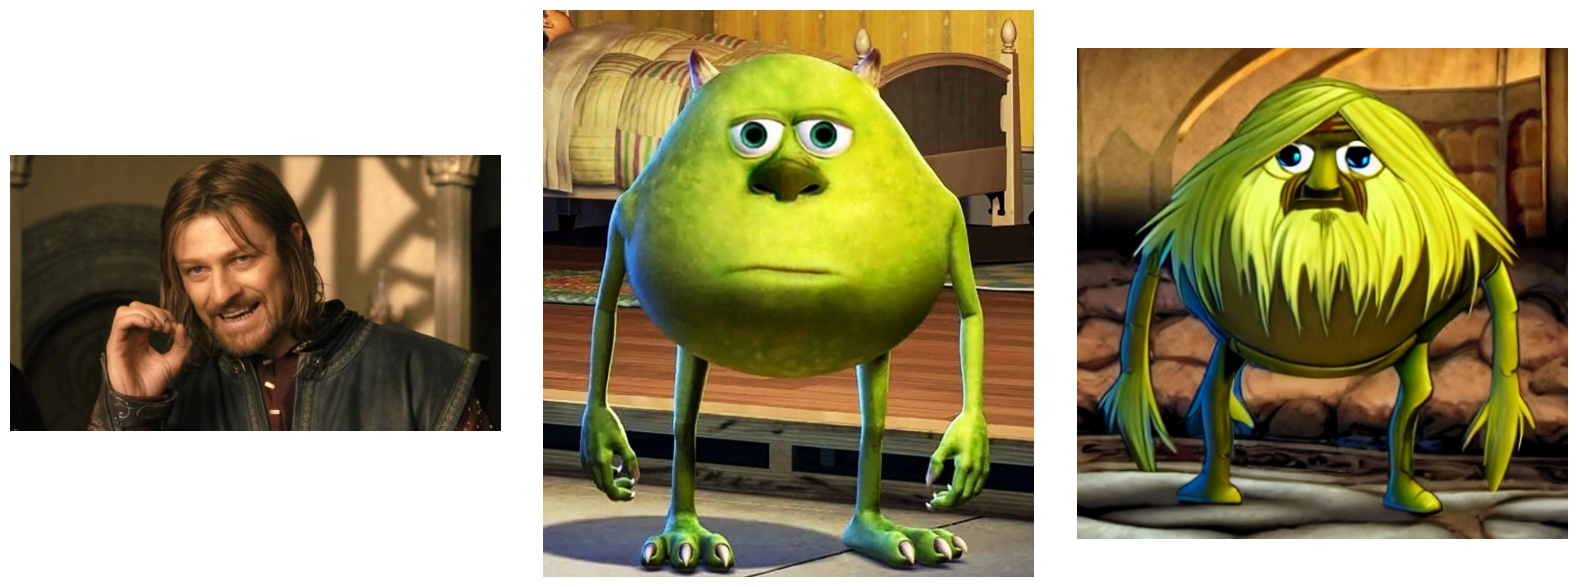

In [4]:
generator = torch.Generator(device="cuda").manual_seed(17) 

content_image = Image.open('../images/boromir.jpg').convert("RGB")
style_image = Image.open('../images/vazovskiy.jpg').convert("RGB")

pipe_images = mixing_pipeline(
    num_inference_steps=50,
    content_image=content_image,
    style_image=style_image,
    noise_strength=0.6,
    slerp_latent_style_strength=0.8,
    slerp_prompt_style_strength=0.1,
    slerp_clip_image_style_strength=0.1,
    guidance_scale=9.0,
    batch_size=1,
    clip_guidance_scale=100,
    generator=generator,
).images

show_images([content_image, style_image, pipe_images[0]], figsize=(16, 8))